In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Configuration
FORECAST_YEARS = range(101, 106)
print("Step 1: Libraries and Setup complete.")


Step 1: Libraries and Setup complete.


In [3]:
# Load historical data
pop_df = pd.read_csv('population_all_teams_year100.csv')
gdp_df = pd.read_csv('statistics_all_teams_year100.csv')
wealth_df = pd.read_csv('wealthy_year100.csv') # New wealth data

# Load weather forecast files
weather_data = {}
for yr in FORECAST_YEARS:
    try:
        weather_data[yr] = pd.read_csv(f'weather_year_{yr}.csv')
    except FileNotFoundError:
        pass

print("Step 2: Data Loading complete (including Wealth data).")

Step 2: Data Loading complete (including Wealth data).


In [4]:
# Aggregate historical wealth data
wealth_annual = wealth_df.groupby('year').agg({
    'net_worth': 'mean'
}).rename(columns={'net_worth': 'avg_net_worth'}).reset_index()

# Aggregate population data
pop_annual = pop_df.groupby('year').agg({
    'income': 'mean',
    'sex': 'count'
}).rename(columns={'sex': 'total_pop', 'income': 'avg_income'}).reset_index()

# Merge all historical data into one training set
train_df = pd.merge(gdp_df, pop_annual, on='year')
train_df = pd.merge(train_df, wealth_annual, on='year')

print("Step 3: Preprocessing complete. Wealth factor (Net Worth) integrated.")
train_df.head()

Step 3: Preprocessing complete. Wealth factor (Net Worth) integrated.


,year,gdp,avg_income,total_pop,avg_net_worth
0,0,947610.99,1895.221980,500,10000.000000
1,1,924027.86,1826.142016,506,10660.119644
2,2,936162.21,1835.612176,510,11315.131255
3,3,827450.82,1612.964561,513,11886.212827
4,4,936712.99,1818.860175,515,12521.981767


In [5]:
# Prepare arrays for trend projection
hist_years = train_df['year'].values.reshape(-1, 1)
future_years_arr = np.array(FORECAST_YEARS).reshape(-1, 1)

# Fit trends for all three major drivers
pop_trend = LinearRegression().fit(hist_years, train_df['total_pop'])
inc_trend = LinearRegression().fit(hist_years, train_df['avg_income'])
wealth_trend = LinearRegression().fit(hist_years, train_df['avg_net_worth'])

# Create future feature set for years 101-105
future_df = pd.DataFrame({
    'year': FORECAST_YEARS,
    'total_pop': pop_trend.predict(future_years_arr),
    'avg_income': inc_trend.predict(future_years_arr),
    'avg_net_worth': wealth_trend.predict(future_years_arr)
})

print("Step 4: Future trends for Population, Income, and Wealth projected.")

Step 4: Future trends for Population, Income, and Wealth projected.


In [6]:
# Define features (Now including avg_net_worth)
features = ['avg_income', 'total_pop', 'avg_net_worth']
X = train_df[features]
y = train_df['gdp']

# Train the enhanced Model
gdp_model = LinearRegression().fit(X, y)

# Predict Future GDP
future_df['predicted_gdp'] = gdp_model.predict(future_df[features])

print("Step 5: GDP Prediction (Wealth-Adjusted) complete.")

Step 5: GDP Prediction (Wealth-Adjusted) complete.



--- FINAL WEALTH-ADJUSTED GDP FORECAST 101-105 ---
 year  avg_net_worth  predicted_gdp
  101   30870.427291   1.159198e+06
  102   30998.975453   1.160929e+06
  103   31127.523615   1.162660e+06
  104   31256.071776   1.164391e+06
  105   31384.619938   1.166123e+06

Success: Data exported to 'final_gdp_wealth_forecast.csv'
Success: Plot saved as 'gdp_wealth_forecast_plot.png'


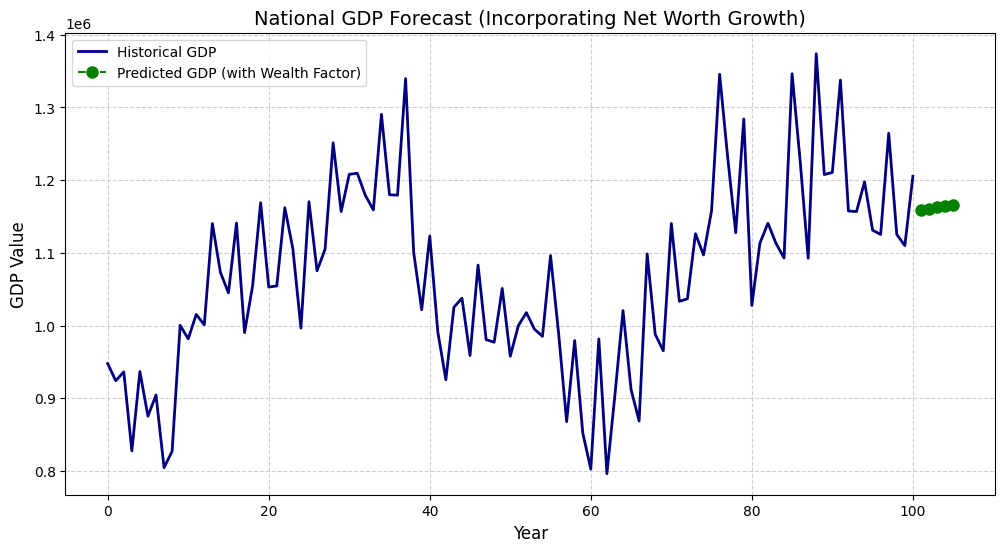

In [7]:

# 1. Display numerical summary in the console
print("\n--- FINAL WEALTH-ADJUSTED GDP FORECAST 101-105 ---")
print(future_df[['year', 'avg_net_worth', 'predicted_gdp']].to_string(index=False))

# 2. Export the final data to CSV (for Excel)
future_df.to_csv('final_gdp_wealth_forecast.csv', index=False)
print("\nSuccess: Data exported to 'final_gdp_wealth_forecast.csv'")

# 3. Create the Visualization
plt.figure(figsize=(12, 6))

# Plot Historical Data
plt.plot(train_df['year'], train_df['gdp'], label='Historical GDP', color='navy', linewidth=2)

# Plot Forecasted Data
plt.plot(future_df['year'], future_df['predicted_gdp'], 'o--', 
         label='Predicted GDP (with Wealth Factor)', color='green', markersize=8)

# Formatting the Chart
plt.title('National GDP Forecast (Incorporating Net Worth Growth)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 4. SAVE THE PLOT (Use this to submit)
plt.savefig('gdp_wealth_forecast_plot.png')
print("Success: Plot saved as 'gdp_wealth_forecast_plot.png'")

# Optional: Still show the plot in the notebook
plt.show()


--- GDP IMPACT: SUSTAINED POLICY PLAN (101-105) ---
 year  predicted_gdp  final_policy_gdp
  101   1.159198e+06      1.209043e+06
  102   1.160929e+06      1.163251e+06
  103   1.162660e+06      1.164985e+06
  104   1.164391e+06      1.166720e+06
  105   1.166123e+06      1.168455e+06


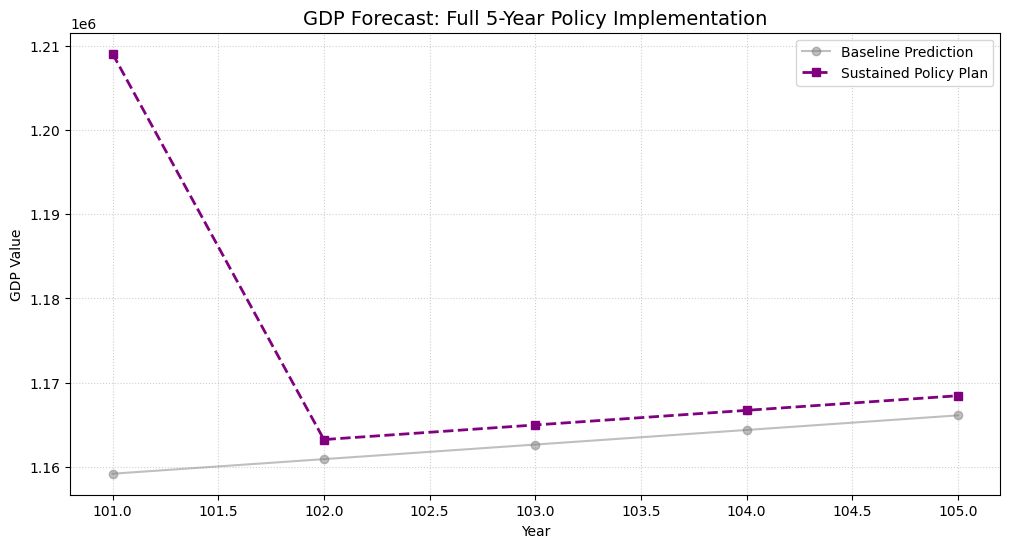

In [10]:
# Policy Simualation


# Create a copy for simulation
policy_df = future_df.copy()

# 1. TRADE AGREEMENT (Neighboring Island)
# Logic: +5% GDP bonus applied ONLY to Year 101
policy_df['trade_benefit'] = 0.0
policy_df.loc[policy_df['year'] == 101, 'trade_benefit'] = policy_df.loc[policy_df['year'] == 101, 'predicted_gdp'] * 0.05

# 2. TRAINING PROGRAMMES (Recurring 5-Year Investment)
# Logic: Applied to ALL 5 years. 
# Cost: 1% of GDP per year to train unemployed citizens.
# Benefit: 0.8% GDP boost per year from a more skilled workforce.
policy_df['training_cost'] = -(policy_df['predicted_gdp'] * 0.01)
policy_df['training_benefit'] = policy_df['predicted_gdp'] * 0.008
policy_df['training_net'] = policy_df['training_cost'] + policy_df['training_benefit']

# 3. COMMUNITY CENTERS (One-time investment, 5-year effect)
# Logic: Applied in Year 101.
# Cost: 0.5% GDP tax in Year 101 only.
# Benefit: 0.4% GDP boost for the following 5 years (102-105 in our range).
policy_df['community_impact'] = 0.0
# Initial Investment (Year 101)
policy_df.loc[policy_df['year'] == 101, 'community_impact'] = -(policy_df.loc[policy_df['year'] == 101, 'predicted_gdp'] * 0.005)
# Sustained Benefit (Years 102-105)
policy_df.loc[policy_df['year'] > 101, 'community_impact'] = policy_df.loc[policy_df['year'] > 101, 'predicted_gdp'] * 0.004

# Calculate Final Adjusted GDP
policy_df['final_policy_gdp'] = (
    policy_df['predicted_gdp'] + 
    policy_df['trade_benefit'] + 
    policy_df['training_net'] + 
    policy_df['community_impact']
)

# --- Display Results ---
print("\n--- GDP IMPACT: SUSTAINED POLICY PLAN (101-105) ---")
cols_to_show = ['year', 'predicted_gdp', 'final_policy_gdp']
print(policy_df[cols_to_show].to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(policy_df['year'], policy_df['predicted_gdp'], 'o-', label='Baseline Prediction', color='gray', alpha=0.5)
plt.plot(policy_df['year'], policy_df['final_policy_gdp'], 's--', label='Sustained Policy Plan', color='purple', linewidth=2)

plt.title('GDP Forecast: Full 5-Year Policy Implementation', fontsize=14)
plt.xlabel('Year')
plt.ylabel('GDP Value')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

# Save the plot
plt.savefig('predicted_policy_.png')
plt.show()

# Export for your report
policy_df.to_csv('predicted_policy_.csv', index=False)